# Import and misc

In [1]:
# Instal latest torch and torchaudio

In [2]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

# Task

In [3]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [4]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

--2022-10-31 06:20:43--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.253.115.128, 2607:f8b0:4004:c06::80
Connecting to download.tensorflow.org (download.tensorflow.org)|172.253.115.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   229MB/s    in 6.4s    

2022-10-31 06:20:50 (223 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [5]:
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [6]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [7]:
dataset.csv.sample(5)

,path,keyword,label
4323,speech_commands/bird/5de8f2f0_nohash_0.wav,bird,0
64388,speech_commands/house/a759efbc_nohash_2.wav,house,0
22750,speech_commands/six/83f9c4ab_nohash_0.wav,six,0
50342,speech_commands/yes/25132942_nohash_1.wav,yes,0
17880,speech_commands/stop/f19c1390_nohash_4.wav,stop,0


### Augmentations

In [8]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [9]:
indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [10]:
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

In [11]:
train_set[0]

{'wav': tensor([-0.0152, -0.0155, -0.0149,  ...,  0.0126, -0.0022, -0.0026]),
 'keywors': 'five',
 'label': 0}

### Sampler for oversampling:

In [12]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [13]:
train_sampler = get_sampler(train_set.csv['label'].values)

In [14]:
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [15]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [16]:
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [17]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

# Streaming

In [248]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output


In [18]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt
import random


In [324]:
class StreamCRNN(CRNN):
    def __init__(self, config):
        super().__init__(config)
    
    def stream_forward(self, input, hidden=None):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, hidden = self.gru(conv_output, hidden) if hidden is not None else self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output, hidden

    
class Streaming():
    def __init__(self,  max_window_length=40, streaming_step_size=2):
        self.max_window_length = max_window_length
        self.streaming_step_size = streaming_step_size
        
    def stream(self, model, input):
        model.eval()
        kernel_width = model.conv[0].kernel_size[1]
        stride = model.conv[0].stride[-1]
        max_window_length = self.max_window_length - (self.max_window_length - kernel_width) % stride
        hidden = None
        
        output, hidden = model.stream_forward(input[:,:,:max_window_length])
        result = output.unsqueeze(1)

        for i in range(max_window_length, input.shape[-1], self.streaming_step_size):
            output, hidden = model.stream_forward(input[:,:, i - max_window_length + 1 : i + 1], hidden=hidden)
            output = output.unsqueeze(1)
            result = torch.cat((result, output[:, -1:]), dim=1)
        probs = F.softmax(result, dim=-1)[0].detach().numpy()
        clear_output()
        plt.plot(list(range(self.max_window_length // 2, probs.shape[0] * self.streaming_step_size + self.max_window_length // 2, self.streaming_step_size)), probs[:,1])
        return result

In [325]:
#loading teacher model

tconfig = TaskConfig()
teacher = StreamCRNN(tconfig)
teacher.load_state_dict(torch.load('teacher_model.pt', map_location='cpu'))
teacher.eval()

StreamCRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [326]:
for i, t in enumerate(train_set):
    if t['label'] == 1:
        print(i)
        break

92


In [327]:
import random

def seed_all(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

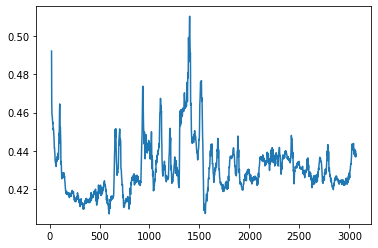

In [331]:
seed_all(112)

st = Streaming(max_window_length = 40, streaming_step_size=2)

audio = torch.cat([train_set[i]['wav'] for i in range(15)] + [train_set[92]['wav']] + [train_set[i]['wav'] for i in range(15, 30)])
mel = melspec_train(audio.unsqueeze(0).to(tconfig.device))
result = st.stream(teacher, mel) 